In [1]:
import torchvision, time, os, copy
from torchvision import transforms
from torchvision import datasets
from torchvision import models
import torch
print('torch.__version__ : ', torch.__version__)
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import numpy as np
from matplotlib import pyplot as plt

torch.__version__ :  1.4.0a0+7f73f1d


In [25]:
print(time.asctime(time.localtime(time.time())))

Fri Jun 12 15:12:51 2020


In [2]:

#quit()

# Data augmentation and normalization for training
# Just normalization for validation
#there isno testing 
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224), # ImageNet models were trained on 224x224 images
        transforms.RandomHorizontalFlip(), # flip horizontally 50% of the time - increases train set variability
        transforms.ToTensor(), # convert it to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet models expect this norm
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [3]:

data_dir = 'Downloads/hymenoptera_data'
# data_dir = 'hymenoptera_data'


In [4]:
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['training', 'validation']
}

In [5]:
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['training', 'validation']
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
class_names = image_datasets['training'].classes


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('device', device)

device cuda:0


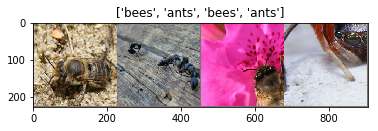

In [8]:
# Helper function for displaying images
def imshow(inp, title=None):
    
#    import matplotlib as plt  # AttributeError: module 'matplotlib' has no attribute 'imshow'
    
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#calls the funcion defined above
imshow(out, title=[class_names[x] for x in classes])

In [9]:
#should we have the labelling - json here ?


In [10]:
# should we have get modell here ?

In [11]:
# should we have build modell here?

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time

In [13]:
# there could be functions more at the begin
# def get_model():
# def build_model(hidden_layers, image_datasets__class_to_idx):

# Download a pre-trained ResNet18 model and freeze its weights  XXXXXX
# AttributeError: 'DenseNet' object has no attribute 'fc'
# To change to Densenet is too complex, i cant see the differences in the documentation
# model = torchvision.models.densenet201(pretrained=True)
model = torchvision.models.resnet18(pretrained=True)
# model = torchvision.models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features 
#resnet34
#num_ftrs = model.fc.in_features #resnet18
#num_ftrs = model.fc2.in_features #try for densenet
model.fc = nn.Linear(num_ftrs, 2) 
# resnet 34
# model.fc = nn.Linear(num_ftrs, 2) # resnet 18
#outp size was102, here 2, Hidden Layers kept with 512
#model.fc2 = nn.Linear(512, 2) # densenet 201

# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
# Optimizer
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

#Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#where are the hidden layers defined?

In [14]:
# Function call to train model
model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)
# model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=4)


Epoch 1/10
----------


/home/klaus/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


training Loss: 0.7905 Acc: 0.5943
validation Loss: 0.3132 Acc: 0.8600

Epoch 2/10
----------
training Loss: 0.5239 Acc: 0.7705
validation Loss: 0.2335 Acc: 0.9067

Epoch 3/10
----------
training Loss: 0.4772 Acc: 0.8074
validation Loss: 0.1828 Acc: 0.9400

Epoch 4/10
----------
training Loss: 0.4954 Acc: 0.7418
validation Loss: 0.1883 Acc: 0.9467

Epoch 5/10
----------
training Loss: 0.5320 Acc: 0.7787
validation Loss: 0.2363 Acc: 0.9267

Epoch 6/10
----------
training Loss: 0.4947 Acc: 0.8156
validation Loss: 0.1760 Acc: 0.9467

Epoch 7/10
----------
training Loss: 0.3108 Acc: 0.8689
validation Loss: 0.1984 Acc: 0.9400

Epoch 8/10
----------
training Loss: 0.2973 Acc: 0.8893
validation Loss: 0.1742 Acc: 0.9533

Epoch 9/10
----------
training Loss: 0.2942 Acc: 0.8566
validation Loss: 0.1703 Acc: 0.9467

Epoch 10/10
----------
training Loss: 0.3034 Acc: 0.8770
validation Loss: 0.1816 Acc: 0.9400

Training complete in 13m 22s
Best val Acc: 0.000000


In [15]:
#Store the model

In [16]:
#retrieve the model

In [17]:
#use the model for operations

In [18]:
# Add the path to torchvision - change as needed
import sys
sys.path.insert(0, '/home/klaus/python-envs/env/lib/python3.6/site-packages/vision')



# Imports
import torch, json
import numpy as np
from torchvision import datasets, models, transforms
from PIL import Image

# Import matplotlib and configure it for pretty inline plots
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Prepare the labels
#with open('Downloads/hymenoptera_data/imagenet-simple-labels.json') as f:
##with open("imagenet-simple-labels.json") as f:
#    labels = json.load(f)

    
    


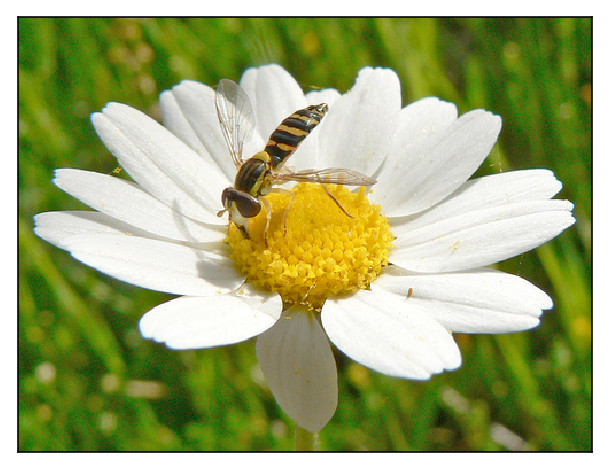

In [19]:
# This seems to be the Test Example where I want a prediction    
# Choose an image to pass through the model
# Choose an image to pass through the model
test_image = 'Downloads/hymenoptera_data/testdata_prediction/predBb.jpg'  
# test_image = 'Downloads/hymenoptera_data/testdata_prediction/predB.jpg'  #Predicted class is: jellyfish
# test_image = 'Downloads/hymenoptera_data/testdata_prediction/predE.jpg' # Predicted class is: Samoyed
#test_image = 'Downloads/hymenoptera_data/testdata_prediction/predB.jpg'
#test_image = 'images/dog.jpg'
# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# Load the image
image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image).unsqueeze(0).cuda()

# Download the model if it's not there already. It will take a bit on the first run, after that it's fast
model = models.resnet50(pretrained=True)
# Send the model to the GPU 
model.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
model.eval();




In [20]:
# seems thats the latest when its necessary
# Prepare the labels
with open('Downloads/hymenoptera_data/imagenet-simple-labels.json') as f:
#with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)


# Get the 1000-dimensional model output
out = model(image)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

IndexError: list index out of range

In [ ]:
# seems to have no function
import time
fps = np.zeros(200)
with torch.no_grad(): # speed it up by not computing gradients since we don't need them for inference
    for i in range(200):
        t0 = time.time()
        out = model(image)
        fps[i] = 1 / (time.time() - t0)